Successfully loaded LSTM results
Successfully loaded raw data
Training set size: 2039
Test set size: 510

Training LSTM-GARCH model...
Epoch [10/50], Train Loss: 0.0219, Val Loss: 0.0395
Epoch [20/50], Train Loss: 0.0189, Val Loss: 0.0364
Epoch [30/50], Train Loss: 0.0180, Val Loss: 0.0334
Epoch [40/50], Train Loss: 0.0182, Val Loss: 0.0339
Epoch [50/50], Train Loss: 0.0162, Val Loss: 0.0322


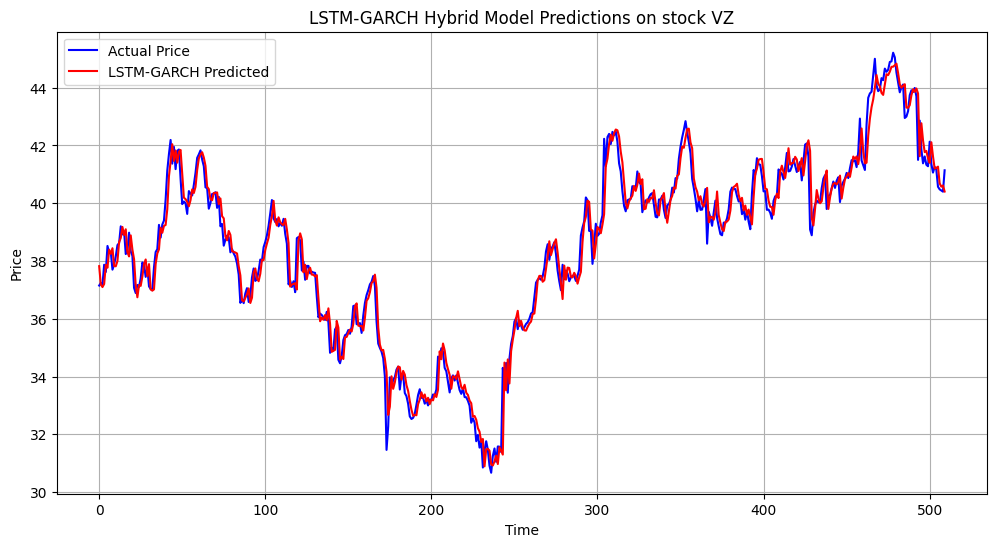

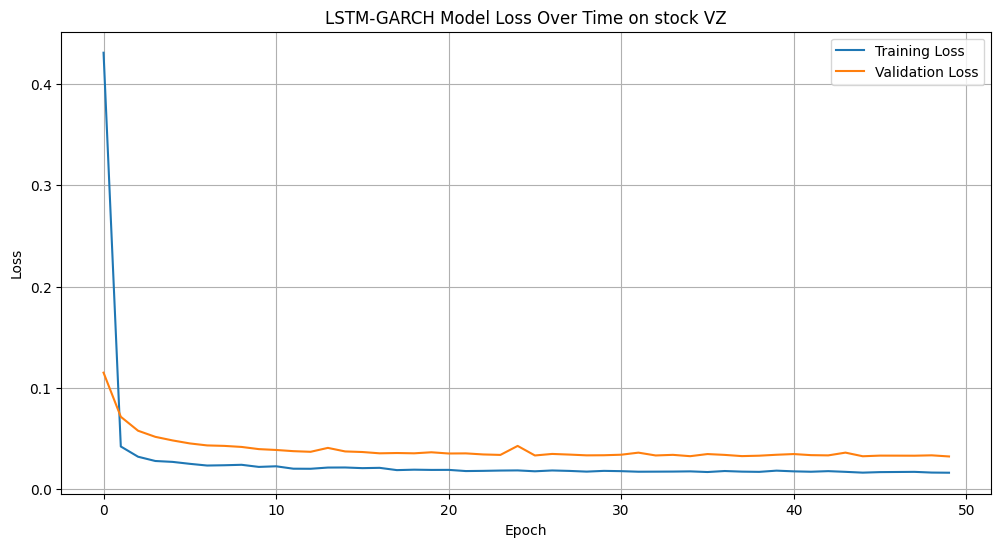


Models Comparison:
        Model       MSE       MAE       R^2
0        LSTM  0.309226  0.400965  0.970175
1       GARCH  1.085854  0.761944 -0.038727
2  LSTM-GARCH  0.302884  0.392033  0.969100

Model and results saved to e:\PG Year 2\Semester 1\CS6140 10931 Machine Learning\Project\Cheyi Wu\FinalProject\Garch\LSTM-Garch\VZ


In [26]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from arch import arch_model
import os
from sklearn.metrics import r2_score  # 引入 R² 计算

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 数据集类
class PriceDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length
        self.price_scaler = StandardScaler()
        self.feature_scaler = StandardScaler()
        
        # 标准化价格
        self.scaled_prices = self.price_scaler.fit_transform(data['close'].values.reshape(-1, 1))
        
        # 标准化其他特征
        features = data.drop(['close', 'timestamp'], axis=1, errors='ignore')
        self.scaled_features = self.feature_scaler.fit_transform(features)
        
    def __len__(self):
        return len(self.data) - self.sequence_length
        
    def __getitem__(self, idx):
        X = np.concatenate([
            self.scaled_features[idx:idx+self.sequence_length],
            self.scaled_prices[idx:idx+self.sequence_length]
        ], axis=1)
        y = self.scaled_prices[idx+self.sequence_length]
        
        return torch.FloatTensor(X), torch.FloatTensor(y)

# LSTM-GARCH混合模型
class LSTM_GARCH(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM_GARCH, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # LSTM层
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        
        # GARCH层参数
        self.omega = nn.Parameter(torch.tensor([0.1]))
        self.alpha = nn.Parameter(torch.tensor([0.1]))
        self.beta = nn.Parameter(torch.tensor([0.8]))
        
        # 全连接层
        self.fc1 = nn.Linear(hidden_dim, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64 + 1, output_dim)  # +1 for GARCH volatility
        
    def forward(self, x, prev_sigma=None):
        # LSTM部分
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        lstm_last = lstm_out[:, -1, :]
        
        # GARCH部分
        if prev_sigma is None:
            prev_sigma = torch.sqrt(self.omega / (1 - self.alpha - self.beta))
        
        sigma_t = torch.sqrt(self.omega + 
                           self.alpha * torch.pow(x[:, -1, 0], 2) + 
                           self.beta * torch.pow(prev_sigma, 2))
        
        # 全连接层处理
        out = torch.relu(self.fc1(lstm_last))
        out = torch.relu(self.fc2(out))
        
        # 合并LSTM和GARCH的输出
        combined = torch.cat((out, sigma_t.unsqueeze(1)), dim=1)
        
        # 最终预测
        out = self.fc3(combined)
        return out, sigma_t

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            optimizer.zero_grad()
            y_pred, sigma_t = model(X_batch)
            loss = criterion(y_pred, y_batch)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss = train_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # 验证阶段
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val = X_val.to(device)
                y_val = y_val.to(device)
                
                y_pred, sigma_t = model(X_val)
                val_loss += criterion(y_pred, y_val).item()
        
        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    return train_losses, val_losses

def main():
    # 设置基础路径和输出路径
    BASE_DIR = os.path.abspath(os.path.join("..", ".."))  # 获取当前路径的上两级目录
    COMPANY = "VZ"
    OUTPUT_DIR = os.path.join(BASE_DIR, "Garch", "LSTM-Garch", COMPANY)
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    try:
        # 读取LSTM结果
        lstm_results = pd.read_csv(os.path.join(BASE_DIR, "LSTM", COMPANY, "actuals_vs_predictions.csv"))
        print("Successfully loaded LSTM results")
        
        # 读取原始数据
        df = pd.read_csv(os.path.join(BASE_DIR, "input data", "Reversed_"+ str(COMPANY) + "_Data_with_PCA.csv"))
        print("Successfully loaded raw data")
        
        # 数据预处理
        df = df.ffill().bfill()
        
        # GARCH模型部分
        returns = 100 * df['close'].pct_change()
        returns = returns.ffill().bfill()
        
        train_size = int(len(returns) * 0.8)
        train_returns = returns[:train_size]
        test_returns = returns[train_size:]
        
        print(f"Training set size: {len(train_returns)}")
        print(f"Test set size: {len(test_returns)}")
        
        # GARCH模型
        garch_model = arch_model(train_returns, vol='Garch', p=1, q=1)
        garch_results = garch_model.fit(disp='off')
        forecasts = garch_results.forecast(horizon=len(test_returns))
        predicted_vol = np.sqrt(forecasts.variance.values[-1, :])
        
        # LSTM-GARCH混合模型部分
        sequence_length = 30  # 与LSTM_1.ipynb保持一致
        batch_size = 32
        train_size = int(0.8 * len(df))
        
        # 准备数据集
        train_data = df[:train_size].copy()
        val_data = df[train_size-sequence_length:].copy()
        
        train_dataset = PriceDataset(train_data, sequence_length)
        val_dataset = PriceDataset(val_data, sequence_length)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        
        # 模型参数
        input_dim = train_dataset.scaled_features.shape[1] + 1
        hidden_dim = 64
        num_layers = 2
        output_dim = 1
        
        # 初始化模型
        model = LSTM_GARCH(input_dim, hidden_dim, num_layers, output_dim).to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
        num_epochs = 50  # 与LSTM_1.ipynb保持一致
        
        # 训练模型
        print("\nTraining LSTM-GARCH model...")
        train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)
        
        # 模型评估
        model.eval()
        predictions = []
        actuals = []
        
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val = X_val.to(device)
                y_pred, _ = model(X_val)
                predictions.extend(val_dataset.price_scaler.inverse_transform(y_pred.cpu().numpy()))
                actuals.extend(val_dataset.price_scaler.inverse_transform(y_val.numpy().reshape(-1, 1)))
        
        # 绘图和评估
        # 1. LSTM原始预测图
        # plt.figure(figsize=(12, 6))
        # plt.plot(lstm_results['Actual Price'], label='Actual Price', color='blue')
        # plt.plot(lstm_results['Predicted Price'], label='LSTM Predicted', color='orange')
        # plt.title("Original LSTM Model Predictions on stock " + str(COMPANY))
        # plt.xlabel("Time")
        # plt.ylabel("Price")
        # plt.legend()
        # plt.grid(True)
        # plt.savefig(os.path.join(OUTPUT_DIR, 'lstm_predictions.png'))
        # plt.show()

        # 2. LSTM-GARCH混合模型预测图
        plt.figure(figsize=(12, 6))
        plt.plot(actuals, label='Actual Price', color='blue')
        plt.plot(predictions, label='LSTM-GARCH Predicted', color='red')
        plt.title("LSTM-GARCH Hybrid Model Predictions on stock " + str(COMPANY))
        plt.xlabel("Time")
        plt.ylabel("Price")
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(OUTPUT_DIR, 'lstm_garch_predictions.png'))
        plt.show()
        
        # 3. 训练损失曲线
        plt.figure(figsize=(12, 6))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title("LSTM-GARCH Model Loss Over Time on stock " + str(COMPANY))
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(OUTPUT_DIR, 'training_loss.png'))
        plt.show()
        
        # 计算性能指标
        mse_lstm = mean_squared_error(lstm_results['Actual Price'], lstm_results['Predicted Price'])
        mse_garch = mean_squared_error(abs(test_returns), predicted_vol)
        mse_hybrid = mean_squared_error(actuals, predictions)
        
        mae_lstm = mean_absolute_error(lstm_results['Actual Price'], lstm_results['Predicted Price'])
        mae_garch = mean_absolute_error(abs(test_returns), predicted_vol)
        mae_hybrid = mean_absolute_error(actuals, predictions)
        
        # 计算 R² 值
        r2_lstm = r2_score(lstm_results['Actual Price'], lstm_results['Predicted Price'])
        r2_garch = r2_score(abs(test_returns), predicted_vol)
        r2_hybrid = r2_score(actuals, predictions)

        # 创建 DataFrame 并添加 R² 列
        models_comparison = pd.DataFrame({
            'Model': ['LSTM', 'GARCH', 'LSTM-GARCH'],
            'MSE': [mse_lstm, mse_garch, mse_hybrid],
            'MAE': [mae_lstm, mae_garch, mae_hybrid],
            # 'RMSE': [np.sqrt(mse_lstm), np.sqrt(mse_garch), np.sqrt(mse_hybrid)],
            'R^2': [r2_lstm, r2_garch, r2_hybrid]  # 添加 R² 列
        })
        
        print("\nModels Comparison:")
        print(models_comparison)
        
        # 保存结果
        models_comparison.to_csv(os.path.join(OUTPUT_DIR, 'model_comparison.csv'), index=False)
        
        results_df = pd.DataFrame({
            'Actual Price': actuals,
            'Predicted Price': predictions
        })
        results_df.to_csv(os.path.join(OUTPUT_DIR, 'lstm_garch_predictions.csv'), index=False)
        
        # 保存模型
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'lstm_garch_model.pth'))
        print(f"\nModel and results saved to {OUTPUT_DIR}")
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise

if __name__ == "__main__":
    main()